# New Demo

In [1]:
using Revise
using HypergraphDetectability
using DataFrames
using Arpack
using LinearAlgebra
using Plots

┌ Info: Precompiling HypergraphDetectability [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphDetectability does not have StatsBase in its dependencies:
│ - If you have HypergraphDetectability checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphDetectability
└ Loading StatsBase into HypergraphDetectability from project dependency, future warnings for HypergraphDetectability are suppressed.


In [2]:
# we will make a hypergraph with 200 nodes in cluster 1, 100 nodes in cluster 2, 100 nodes in cluster 3
N = [200, 100, 100];

# NaN refers to 1 edges, which don't matter
# 90% of 2-edges, 80% of 3-edges, and 90% of 4-edges are within-group. 
P = [NaN, 0.9, 0.8, 0.9];

# each node is incident to, on average, 6 2-edges, 5 3-edges, and 4 4-edges
C = [NaN, 6, 5, 4];

# make the hypergraph
H = plantedPartitionHypergraph(N, C, P);

# true labels
z = vcat([repeat([z], N[z]) for z ∈ 1:length(N)]...);

In [3]:
# generate all the nonbacktracking matrices
B = nonBacktrackingMatrices(H)[1];

# B[1] is the nonbacktracking matrix for 2-edges
# B[2] is the nonbacktracking matrix for 3-edges
# B[3] is the nonbacktracking matrix for 4-edges

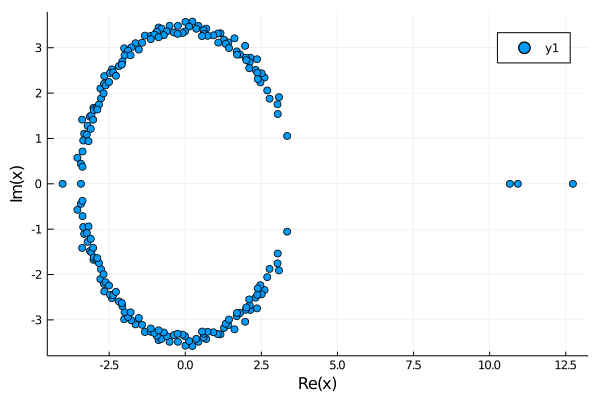

In [4]:
# let's look at the eigenvalues of B[k], the matrix for k-edges

k = 4

E = Arpack.eigs(B[k-1]; nev = 200);
plot(E[1], seriestype = :scatter)

There are two eigenvalues outside the bulk, other than the largest one, because there are 3 clusters. 

In [5]:
# let's compare that to the normalized branching matrix 

# c collects the average k-degree for each k
# M contains the normalized branching matrices (yes, the name of the function is weird)
# bit of a fudge here: this is the *empirical* normalized branching matrix obtained from 
# looking at the data, rather than the *theoretical* matrix obtained from the model parameters
c, M = degreeTensor(H, z; normalized = true);

In [6]:
# let's compare the normalized branching matrix for k-edges
M[k-1,:,:]

3×3 Array{Float64,2}:
  0.477361  -0.462529  -0.435988
 -0.231265   0.658665  -0.231265
 -0.217994  -0.231265   0.646175

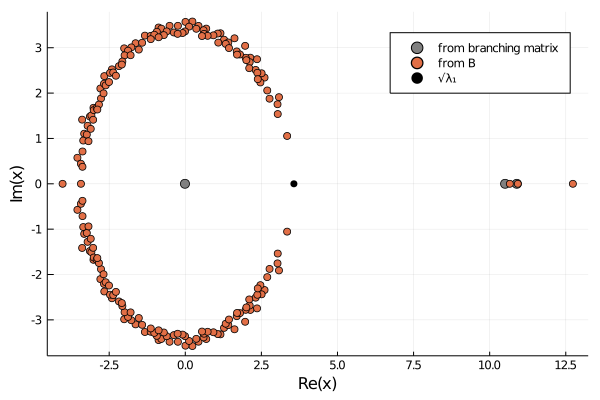

In [7]:
E_ = LinearAlgebra.eigen(M[k-1,:,:]).values;
# hand-waving: once I know the eigenvalues of the normalized branching matrix, I should scale to reflect the facts that
# - each node is connected to, on average, C[k]  k-edges.
# - each k-edge connects a node to k-1 distinct other nodes. 

E_ = E_*C[k]*(k-1) # scaling based on hand-waving above

plot(E_, zero(E_), seriestype = :scatter, markersize = 5, markercolor = "grey", label = "from branching matrix")
plot!(E[1], seriestype = :scatter, label = "from B")
plot!([sqrt(real(E[1][1]))], [0.0], markercolor = "black", label = "√λ₁", seriestype = :scatter)

In this particular case, it looks like the two eigenvalues of the branching matrix may correspond, after the hand-wavy scaling, to the two interesting eigenvalues of $B_k$. It also looks like the radius of the circle is plausibly the square root of the largest eigenvalue? 

# Some Questions

- The above is for individual $B_k$s, what happens for any of this when we add them together? 
- Can we be more concrete about justifying the hand-wavy scaling?
- In what cases can we just explicitly list out eigenvalues/eigenvectors for the branching matrix? 